Spark Approach

In [ ]:
# import pyspark as ps
# spark = (ps.sql.SparkSession.builder 
#         .master("local[4]") 
#         .appName("sparkSQL exercise")
#         .config("spark.sql.caseSensitive", "true")
#         .getOrCreate()
#         )
# sc = spark.sparkContext

# peer = spark.read.json('new.json')

# peer.printSchema()

# peer.createOrReplaceTempView("peer")

# result = spark.sql("""SELECT lang, COUNT(lang)
#             FROM peer 
#             GROUP BY lang
#             """)

# result.show()

Pandas Approach with Manual Approach

In [1]:
import json
from tqdm import tqdm # google this
journals = []
idx = 0

with open('dblpv13.json',"r") as fp:
     for line in tqdm(fp):
        if idx > 100000: 
            break
        try:
            if len(line) < 3:
                continue
            strip_line = line.strip(',')
            journals.append(json.loads(strip_line))
            idx += 1
        except:
            print('fail')
            try:
                strip_line = line.strip(',')
                journals.append(json.loads(strip_line))
                idx += 1
            except:
                idx += 1
                pass

100002it [00:03, 25268.30it/s]


In [2]:
import pandas as pd
journal_df = pd.DataFrame(journals, columns = journals[0].keys())

In [3]:
releases_year = journal_df[['year', '_id']].groupby('year').count().reset_index()
# releases_year = releases_year.drop(index = [0, 1, 120])
releases_year.describe()

,year,_id
count,114.000000,114.000000
mean,1944.736842,877.192982
std,186.951844,1693.478741
min,0.000000,1.000000
25%,1934.250000,4.000000
50%,1962.500000,58.500000
75%,1990.750000,706.500000
max,2019.000000,7052.000000


In [4]:
releases_year = releases_year[(releases_year['year'] > 1500) & (releases_year['year'] < 2022)]

Text(0, 0.5, 'Frequency')

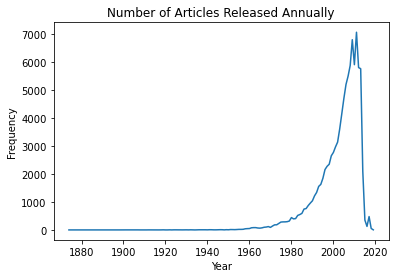

In [5]:
import matplotlib.pyplot as plt

plt.plot(releases_year.iloc[:, 0], releases_year.iloc[:,1])
plt.title("Number of Articles Released Annually")
plt.xlabel("Year")
plt.ylabel("Frequency")
# plt.savefig('img/annual_article_release.png')

Text(0, 0.5, 'Frequency')

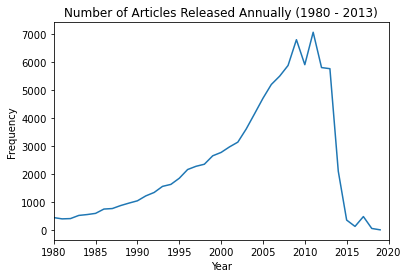

In [6]:
plt.plot(releases_year.iloc[:, 0], releases_year.iloc[:,1])
plt.title("Number of Articles Released Annually (1980 - 2013)")
plt.xlim(1980, 2020)
plt.xlabel("Year")
plt.ylabel("Frequency")
# plt.savefig('img/annual_article_release_1980-2013.png')

In [7]:
test_df = journal_df[(journal_df.year == 0) & (journal_df.n_citation > 10)]

In [8]:
test_df['authors'].str.len()

6915     3
10518    1
11560    1
16047    1
18449    2
26492    2
28524    4
31557    3
44081    2
49824    1
53203    4
Name: authors, dtype: int64

In [245]:
filter_journal = journal_df[(journal_df['year'] > 1500) & (journal_df['year'] < 2022)]
filter_journal

,_id,title,authors,venue,year,keywords,n_citation,page_start,lang,volume,issue,doi,url,abstract
0,{'$oid': '53e99784b7602d9701f3e3f4'},360degree,"[{'_id': {'$oid': '53f46946dabfaec09f24b4ed'},...","{'_id': {'$oid': '53a72b2d20f7420be8c1c5a8'}, ...",2009.0,[],0.0,39,en,,,10.1145/1665137.1665166,"[http://doi.acm.org/10.1145/1665137.1665166, d...",
1,53e99784b7602d9701f3e3f5,3GIO.,NaN,{'type': 0},2011.0,[],0.0,NaN,en,NaN,NaN,NaN,NaN,NaN
2,53e99784b7602d9701f3e133,The relationship between canopy parameters and...,"[{'_id': '53f45728dabfaec09f209538', 'name': '...","{'_id': '53a7297d20f7420be8bd4ae7', 'name_d': ...",2011.0,"[canopy parameters, canopy spectrum, different...",0.0,1930,en,null,null,10.1109/IGARSS.2011.6049503,[http://dx.doi.org/10.1109/IGARSS.2011.6049503],Drought is the first place in all the natural ...
3,53e99784b7602d9701f3e151,A solution to the problem of touching and brok...,"[{'_id': '53f46797dabfaeb22f542630', 'name': '...","{'_id': '53a72a4920f7420be8bfa51b', 'name_d': ...",1993.0,"[handwriting recognition, prototypes, image se...",17.0,602,en,,,10.1109/ICDAR.1993.395663,[http://dx.doi.org/10.1109/ICDAR.1993.395663],
4,53e99784b7602d9701f3e15d,Timing yield estimation using statistical stat...,"[{'_id': '53f43b03dabfaedce555bf2a', 'name': '...","{'_id': '53a72e2020f7420be8c80142', 'name_d': ...",2005.0,"[sequential circuits, statistical distribution...",28.0,2461,en,,,10.1109/ISCAS.2005.1465124,"[http://dx.doi.org/10.1109/ISCAS.2005.1465124,...",As process variations become a significant pro...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,53e998efb7602d9702129fbc,Classification of Human Physical Activities fr...,"[{'_id': '53f4cfe1dabfaeedd377d604', 'name': '...","{'sid': 'BIOSIGNALS 2011', 't': 'J', 'raw': 'B...",2011.0,"[Human activity classification, Statistical pa...",1.0,201,en,,,,NaN,Several applications demanding the development...
99997,53e998efb7602d9702129e44,Full body tracking-based human action recognition,"[{'_id': '53f4337fdabfaedf435622c3', 'name': '...","{'_id': '555037617cea80f95418423f', 'name_d': ...",2008.0,"[particle filter, tracking, hidden markov mode...",12.0,1,en,,,10.1109/ICPR.2008.4761198,[http://dx.doi.org/10.1109/ICPR.2008.4761198],
99998,53e998efb7602d9702129fcf,Optical density visualization and abel reconst...,"[{'_id': '53f45495dabfaee1c0b265ce', 'name': '...","{'_id': '555036b57cea80f95414abed', 'type': 0,...",2007.0,"[optical density, vortex ring]",14.0,5,en,10,1,10.1007/BF03181789,"[http://dx.doi.org/10.1007/BF03181789, https:/...",
99999,53e998efb7602d9702129e49,Parallelization and performance of Conjugate G...,"[{'_id': '53f46490dabfaeee22a4cc1a', 'name': '...","{'_id': '572df208d39c4f5d7aace19d', 'type': 1,...",1991.0,"[conjugate gradient algorithm, cedar hierarchi...",15.0,178,en,26,7,10.1145/109626.109644,"[http://dx.doi.org/10.1145/109626.109644, http...",We analyze the computational structure of the ...


(1960.0, 2020.0)

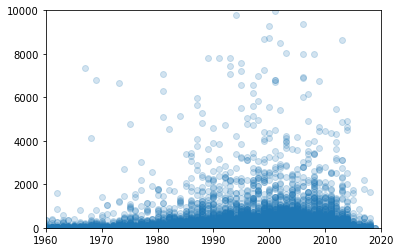

In [10]:
plt.scatter(filter_journal['year'], filter_journal['n_citation'], alpha = 0.2)
plt.ylim(0, 10000)
plt.xlim(1960, 2020)

(array([4.6094e+04, 1.0055e+04, 4.6270e+03, 2.7860e+03, 1.7620e+03,
        1.2830e+03, 9.0300e+02, 6.6800e+02, 5.7200e+02, 4.7900e+02,
        3.7900e+02, 3.1400e+02, 2.4400e+02, 2.2000e+02, 2.0700e+02,
        1.7500e+02, 1.5800e+02, 1.3800e+02, 1.1800e+02, 9.9000e+01,
        1.0100e+02, 8.6000e+01, 8.4000e+01, 7.9000e+01, 6.6000e+01,
        6.5000e+01, 4.4000e+01, 5.0000e+01, 5.4000e+01, 3.8000e+01,
        3.2000e+01, 4.2000e+01, 3.9000e+01, 3.4000e+01, 2.7000e+01,
        2.5000e+01, 2.7000e+01, 1.8000e+01, 3.3000e+01, 1.8000e+01,
        1.9000e+01, 1.9000e+01, 2.7000e+01, 2.9000e+01, 2.2000e+01,
        1.8000e+01, 1.6000e+01, 1.4000e+01, 9.0000e+00, 1.1000e+01]),
 array([  1.  ,  20.96,  40.92,  60.88,  80.84, 100.8 , 120.76, 140.72,
        160.68, 180.64, 200.6 , 220.56, 240.52, 260.48, 280.44, 300.4 ,
        320.36, 340.32, 360.28, 380.24, 400.2 , 420.16, 440.12, 460.08,
        480.04, 500.  , 519.96, 539.92, 559.88, 579.84, 599.8 , 619.76,
        639.72, 659.68, 679.64

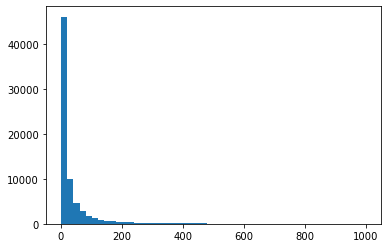

In [11]:
filter_journal_citations = filter_journal[filter_journal['n_citation'] > 0]
sub_1000 = filter_journal_citations[filter_journal_citations['n_citation'] < 1000]
plt.hist(sub_1000['n_citation'], bins = 50)

In [12]:
#Out of 99967 entries - where year provided was between 1500 and 2020 (0.03% removal)
#73044 had 1 or more citations. ~ 73% had been cited more than once.
#0.8% of those entries had been cited more than 1000 times

total = len(filter_journal)
cit_1 = len(filter_journal_citations)
sub = len(sub_1000)

keywords = len(sub_1000[sub_1000['keywords'].str.len() > 0])

print(f'''Out of {total} entries where release year was noted between 1500 and 2020, 
{cit_1} had 1 or more citations. ~ {round(cit_1/total*100,1)}% had been cited more than once.
{cit_1-sub} had been cited more than 1000 times equating to roughly {round((cit_1-sub)/cit_1*100,2)}%.
There are {round(keywords,2)} with keywords notated, roughly {round((sub - keywords)/sub * 100,2)}% have no keywords''')




Out of 99967 entries where release year was noted between 1500 and 2020, 
73044 had 1 or more citations. ~ 73.1% had been cited more than once.
617 had been cited more than 1000 times equating to roughly 0.84%.
There are 56326 with keywords notated, roughly 22.23% have no keywords


In [13]:
from collections import Counter
count_idx_new = Counter()
idx = 0
for keywords in tqdm(sub_1000['keywords']):
#     if idx > 10000:
#         break
    try:
        if len(keywords) == 0:
            idx += 1
            continue
        elif len(keywords) == 1:
            if count_idx_new.get(keywords[0]) is None:
                count_idx_new[keywords[0]] = 1
            else:
                count_idx_new[keywords[0]] += 1
#             print(count_idx_new[keywords])
            idx += 1
        else:
            if count_idx_new.get(keywords[0]) is None:
                count_idx_new[keywords[0]] = 1
            else:
                count_idx_new[keywords[0]] += 1
            idx += 1
#         if not pd.isna(keywords).all() and len(keywords) > 0:
#         count_idx_new += Counter(keywords[0])
#         idx += 1
#         else:
#             idx +=1
#             pass
    except Exception as e:
        print("error ", e ,idx)
#         print(np.isnan(keywords))
        idx+=1
        pass
    
print(count_idx_new.most_common(10))

100%|██████████| 72427/72427 [00:00<00:00, 730184.52it/s]

error  object of type 'float' has no len() 2140
error  object of type 'float' has no len() 2601
error  object of type 'float' has no len() 2662
error  object of type 'float' has no len() 3726
error  object of type 'float' has no len() 4509
error  object of type 'float' has no len() 4606
error  object of type 'float' has no len() 5504
error  object of type 'float' has no len() 6085
error  object of type 'float' has no len() 7156
error  object of type 'float' has no len() 7486
error  object of type 'float' has no len() 7513
error  object of type 'float' has no len() 7533
error  object of type 'float' has no len() 7547
error  object of type 'float' has no len() 7718
error  object of type 'float' has no len() 8395
error  object of type 'float' has no len() 14796
error  object of type 'float' has no len() 14836
error  object of type 'float' has no len() 14949
error  object of type 'float' has no len() 16303
error  object of type 'float' has no len() 17376
error  object of type 'float' has n

In [15]:
display(len(sub_1000[sub_1000['keywords'].str.len() > 0]))
display(len(count_idx_new.keys()))

56326

38510

In [16]:
count_idx_new.most_common(100)

[('Internet', 145),
 ('data mining', 111),
 ('computational complexity', 89),
 ('algorithms', 85),
 ('satisfiability', 68),
 ('null', 67),
 ('neural network', 63),
 ('information retrieval', 59),
 ('first page', 54),
 ('sufficient condition', 53),
 ('indexation', 53),
 ('computer science', 53),
 ('feature extraction', 48),
 ('software system', 48),
 ('computer vision', 48),
 ('optimisation', 47),
 ('Markov processes', 46),
 ('computational geometry', 45),
 ('design', 44),
 ('real time', 44),
 ('CMOS integrated circuits', 44),
 ('internet', 41),
 ('social network', 40),
 ('machine learning', 40),
 ('main result', 39),
 ('business process', 39),
 ('speech recognition', 39),
 ('artificial intelligence', 38),
 ('software engineering', 38),
 ('pattern recognition', 38),
 ('parallel algorithm', 37),
 ('feature selection', 37),
 ('VLSI', 36),
 ('ad hoc networks', 36),
 ('general', 35),
 ('Computational Mathematic', 35),
 ('programming language', 35),
 ('bioinformatics', 35),
 ('Information Sy

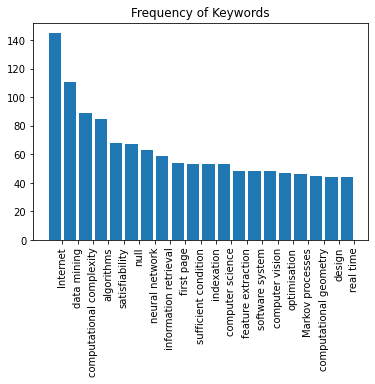

In [19]:
import numpy as np
labels, values = zip(*count_idx_new.most_common(20))
indexes = np.arange(len(labels))
plt.bar(indexes, values)
plt.title("Frequency of Keywords")
plt.xticks(indexes + 0.5, labels, rotation = 90)
plt.show()

In [50]:
idx = 0
# for i in filter_journal_citations['authors']:
#     if idx > 10:
#         break
#     len(i)
type(filter_journal_citations)

pandas.core.frame.DataFrame

In [464]:
def check_column(column):
    try:
        assert(type(column) == pd.Series)
        assert(len(column) == column.shape[0])
    except AssertionError:
        print('Incorrect Type of Input')

def most_common_counter(column, key = None, last = False):
    '''
     Identifies most common attributes of a given Series. Faster Counter
     dict_ refers to if subquery is dictionary. False is for list
     key = specific key in dictionary (assuming dict_ is true)
     last = identify first or last item in list
    '''
    from tqdm import tqdm 
    
    check_column(column)
    count_items = Counter()
    errors = Counter()
    idx = 0
    for items in tqdm(column):
#         if idx > 500: #Limit breaks if required for debugging
#             break
        try:
            if len(items) == 0:
                    idx += 1
                    continue
            if (key is not None) and (type(items) == dict):
                if (len(items) == 1):
                    if count_items.get(items[key]) is None:
                        count_items[items[key]] = 1
                    else:
                        count_items[items[key]] += 1
                    idx += 1
                else:
                    if count_items.get(items[key]) is None:
                        count_items[items[key]] = 1
                    else:
                        count_items[items[key]] += 1
                    idx += 1
            elif (key is not None):
                if (len(items) == 1):
                    if count_items.get(items[-last][key]) is None:
                        count_items[items[-last][key]] = 1
                    else:
                        count_items[items[-last][key]] += 1
                    idx += 1
                else:
                    if count_items.get(items[-last][key]) is None:
                        count_items[items[-last][key]] = 1
                    else:
                        count_items[items[-last][key]] += 1
                    idx += 1
            else:    
                if len(items) == 1:
                    if count_items.get(items[-last]) is None:
                        count_items[items[-last]] = 1
                    else:
                        count_items[items[-last]] += 1
                    idx += 1
                else:
                    if count_items.get(items[-last]) is None:
                        count_items[items[-last]] = 1
                    else:
                        count_items[items[-last]] += 1
                    idx += 1
        except Exception as e:
            e = str(e)
            if errors.get(e) is None:
                errors[e] = 1
            else:
                errors[e] += 1
#             print("error ", e ,idx)
            idx+=1
            pass

    return count_items, errors

In [78]:
idx = 0
for i in sub_1000['authors']:
    if idx > 10:
        break
    print(len(i))
    print(i[-0])
    idx += 1

2
{'_id': '53f46797dabfaeb22f542630', 'name': 'Jairo Rocha'}
3
{'_id': '53f43b03dabfaedce555bf2a', 'name': 'Min Pan'}
4
{'_id': '53f39e3edabfae4b34aa8c4a', 'name': 'Jungil Park', 'sid': '237372'}
2
{'_id': '560175b545cedb3395e59d80', 'name': 'C. Evans'}
4
{'name': 'Jean-marc Deshouillers', 'sid': '134541', '_id': '53f42c7cdabfaedf43509437'}
3
{'email': 'harimsri@math.uvic.ca', 'gid': '5b869a4fe1cd8e14a38d67b5', '_id': '53f49508dabfaeb4c677b4a4', 'name': 'Hiromasa Habuchi', 'org': 'Department of Mathematics and Statistics, University of Victoria, Victoria, BC, V8W 3R4, Canada', 'orgid': '5f71b2841c455f439fe3c6c9'}
4
{'_id': '53f46210dabfaedf43634cba', 'name': 'El Mohajir, Mohammed', 'org': 'FSDM, USMBA, Fez, Morocco|c|', 'gid': '5b86c21ae1cd8e14a39e6b14', 'orgid': '5f71b2811c455f439fe3c5b7'}
2
{'_id': '53f43c87dabfaedf435b42c8', 'name': 'McDonald Mark W'}
1
{'_id': '548a2e3ddabfae9b40134fbc', 'name': 'Harry M. Sneed'}
2
{'_id': '54328b5ddabfaeb4c6a8b965', 'name': 'W.R. Butt'}
1
{'name':

In [465]:
first_name_all, errors_first_name_all = most_common_counter(filter_journal['authors'], key = 'name', last = False)
# results.most_common(5)
# errors.most_common(5)

100%|██████████| 99967/99967 [00:00<00:00, 570245.73it/s]


In [468]:
first_name_all.most_common(20)

[('Karl Rihaczek', 122),
 ('Dirk Fox', 62),
 ('Alois Potton', 55),
 ('Peter G. Neumann', 51),
 ('Johann Bizer', 50),
 ('Edmond Bianco', 47),
 ('&NA;', 42),
 ('Peter J. Denning', 39),
 ('Richard Mateosian', 39),
 ('David Alan Grier', 38),
 ('Gunter Dueck', 35),
 ('Noga Alon', 34),
 ('Nachum Dershowitz', 32),
 ('Burt Kaliski', 28),
 ('Peter Mertens', 28),
 ('Friedrich L. Bauer', 28),
 ('Not Available Not Available', 27),
 ('Ramesh Jain', 26),
 ('George Neville-Neil', 26),
 ('Gary Singh', 26)]

In [134]:
first_name_all.most_common(20)

[('Karl Rihaczek', 122),
 ('Dirk Fox', 62),
 ('Alois Potton', 55),
 ('Peter G. Neumann', 51),
 ('Johann Bizer', 50),
 ('Edmond Bianco', 47),
 ('&NA;', 42),
 ('Peter J. Denning', 39),
 ('Richard Mateosian', 39),
 ('David Alan Grier', 38),
 ('Gunter Dueck', 35),
 ('Noga Alon', 34),
 ('Nachum Dershowitz', 32),
 ('Burt Kaliski', 28),
 ('Peter Mertens', 28),
 ('Friedrich L. Bauer', 28),
 ('Not Available Not Available', 27),
 ('Ramesh Jain', 26),
 ('George Neville-Neil', 26),
 ('Gary Singh', 26)]

In [135]:
last_name_all, errors_last_name_all = most_common_counter(filter_journal['authors'], dict_ = True, key = 'name', last = True)
last_name_all.most_common(20)


100%|██████████| 99967/99967 [00:00<00:00, 593481.05it/s]


[('Karl Rihaczek', 121),
 ('Dirk Fox', 64),
 ('Alois Potton', 55),
 ('Johann Bizer', 50),
 ('Peter G. Neumann', 49),
 ('Edmond Bianco', 47),
 ('&NA;', 41),
 ('Moshe Y. Vardi', 40),
 ('Richard Mateosian', 39),
 ('Gunter Dueck', 35),
 ('Ramesh Jain', 35),
 ('Peter J. Denning', 33),
 ('David Alan Grier', 30),
 ('Peter Mertens', 29),
 ('Burt Kaliski', 28),
 ('Not Available Not Available', 27),
 ('Friedrich L. Bauer', 27),
 ('Saharon Shelah', 27),
 ('George Neville-Neil', 27),
 ('Bertrand Meyer', 26)]

In [132]:
last_name_cit, errors_last_name_xit = most_common_counter(filter_journal_citations['authors'], dict_ = True, key = 'name', last = True)
last_name_cit.most_common(10)

100%|██████████| 73044/73044 [00:00<00:00, 610658.80it/s]


[('Moshe Y. Vardi', 37),
 ('Peter G. Neumann', 34),
 ('Ramesh Jain', 28),
 ('Peter J. Denning', 27),
 ('Moshe Tennenholtz', 25),
 ('Derick Wood', 24),
 ('V. S. Subrahmanian', 24),
 ('Saharon Shelah', 23),
 ('Azriel Rosenfeld', 22),
 ('Toby Walsh', 22)]

In [133]:
first_name_cit, errors_first_name_xit = most_common_counter(filter_journal_citations['authors'], dict_ = True, key = 'name', last = False)
first_name_cit.most_common(10)

100%|██████████| 73044/73044 [00:00<00:00, 633678.01it/s]


[('Peter G. Neumann', 36),
 ('Peter J. Denning', 33),
 ('Noga Alon', 32),
 ('Nachum Dershowitz', 29),
 ('Prosenjit Bose', 21),
 ('Luca Cardelli', 21),
 ('Ramesh Jain', 18),
 ('Dirk Fox', 17),
 ('Donald E. Knuth', 17),
 ('Béla Bollobás', 17)]

In [436]:
def add_column(df, orig_col, new_col, key = None, last = False):
    '''
     Extracts Information from internal dictionaries or lists contained in DataFrame original column
     Adds as new column to original df
     Returns error counter with number of errors encountered.
     
     key = specific key in dictionary (assuming line is dictionary - will return emtpy list otherwise)
     last = identify first or last item in list
    '''
    from tqdm import tqdm
    temp_df = pd.Series(np.nan, index = np.arange(len(df.index)))
    errors = Counter()
    idx = 0
    for items in tqdm(df[orig_col]):
        try:
            if (key is not None) and (type(items) == dict):
                if len(items) == 0:
                    idx += 1
                    continue
                elif (len(items) == 1):
                    temp_df.loc[idx] = items[key]
                    idx += 1
                else:
                    temp_df.loc[idx] = items[key]
                    idx += 1
            elif (key is not None):
                if len(items) == 0:
                    idx += 1
                    continue
                elif (len(items) == 1):
                    temp_df.loc[idx] = items[-last][key]
                    idx += 1
                else:
                    temp_df.loc[idx] = items[-last][key]
                    idx += 1
            else:    
                if len(items) == 0:
                    idx += 1
                    continue
                elif (len(items) == 1):
                    temp_df.loc[idx] = items[-last]
                    idx += 1
                else:
                    temp_df.loc[idx] = items[-last]
                    idx += 1
               
        except Exception as e:
            e = str(e)
            if errors.get(e) is None:
                errors[e] = 1
            else:
                errors[e] += 1
            print("error at ", idx, ". ", e)
            idx+=1
            pass
    
    temp_df = df_reindex(df, temp_df)
    df[new_col] = temp_df
    del temp_df
    
    return errors
    

In [437]:
# type(filter_journal.iloc[4].venue) == dict
add_column(filter_journal, 'venue', 'venue_name', 'raw')

  2%|▏         | 2354/99967 [00:00<00:08, 11863.21it/s]

error at  1 .  'raw'
error at  18 .  'raw'
error at  61 .  'raw'
error at  68 .  'raw'
error at  70 .  'raw'
error at  71 .  'raw'
error at  72 .  'raw'
error at  73 .  'raw'
error at  74 .  'raw'
error at  76 .  'raw'
error at  77 .  'raw'
error at  79 .  'raw'
error at  133 .  'raw'
error at  169 .  'raw'
error at  175 .  'raw'
error at  179 .  object of type 'float' has no len()
error at  229 .  'raw'
error at  240 .  'raw'
error at  242 .  'raw'
error at  243 .  'raw'
error at  244 .  'raw'
error at  246 .  'raw'
error at  247 .  'raw'
error at  248 .  'raw'
error at  249 .  'raw'
error at  250 .  'raw'
error at  251 .  'raw'
error at  252 .  'raw'
error at  253 .  'raw'
error at  254 .  'raw'
error at  255 .  'raw'
error at  256 .  'raw'
error at  257 .  'raw'
error at  258 .  'raw'
error at  259 .  'raw'
error at  260 .  'raw'
error at  261 .  'raw'
error at  262 .  'raw'
error at  263 .  'raw'
error at  376 .  'raw'
error at  435 .  'raw'
error at  436 .  'raw'
error at  439 .  

  6%|▌         | 5730/99967 [00:00<00:06, 15186.27it/s]

error at  2747 .  object of type 'float' has no len()
error at  3086 .  object of type 'float' has no len()
error at  3204 .  object of type 'float' has no len()
error at  3207 .  object of type 'float' has no len()
error at  3208 .  object of type 'float' has no len()
error at  3744 .  object of type 'float' has no len()
error at  3745 .  object of type 'float' has no len()
error at  3799 .  object of type 'float' has no len()
error at  3860 .  object of type 'float' has no len()
error at  3897 .  object of type 'float' has no len()
error at  3915 .  object of type 'float' has no len()
error at  4202 .  object of type 'float' has no len()
error at  4366 .  object of type 'float' has no len()
error at  4462 .  object of type 'float' has no len()
error at  4660 .  object of type 'float' has no len()
error at  4773 .  object of type 'float' has no len()
error at  4847 .  object of type 'float' has no len()
error at  4890 .  object of type 'float' has no len()
error at  4941 .  object of 

  9%|▉         | 9197/99967 [00:00<00:05, 16514.87it/s]

error at  6475 .  object of type 'float' has no len()
error at  6571 .  object of type 'float' has no len()
error at  6650 .  object of type 'float' has no len()
error at  6829 .  object of type 'float' has no len()
error at  6914 .  object of type 'float' has no len()
error at  7134 .  object of type 'float' has no len()
error at  7136 .  object of type 'float' has no len()
error at  7268 .  object of type 'float' has no len()
error at  8174 .  object of type 'float' has no len()
error at  8177 .  object of type 'float' has no len()
error at  8344 .  object of type 'float' has no len()
error at  8509 .  object of type 'float' has no len()
error at  8510 .  object of type 'float' has no len()
error at  8609 .  object of type 'float' has no len()
error at  8781 .  object of type 'float' has no len()
error at  8985 .  object of type 'float' has no len()
error at  9036 .  object of type 'float' has no len()
error at  9101 .  object of type 'float' has no len()
error at  9161 .  object of 

 13%|█▎        | 12647/99967 [00:00<00:05, 16834.61it/s]

error at  10507 .  object of type 'float' has no len()
error at  10508 .  object of type 'float' has no len()
error at  10530 .  object of type 'float' has no len()
error at  10531 .  object of type 'float' has no len()
error at  10570 .  object of type 'float' has no len()
error at  10575 .  object of type 'float' has no len()
error at  10661 .  object of type 'float' has no len()
error at  10705 .  object of type 'float' has no len()
error at  10720 .  object of type 'float' has no len()
error at  10749 .  'raw'
error at  10859 .  object of type 'float' has no len()
error at  10871 .  object of type 'float' has no len()
error at  11025 .  object of type 'float' has no len()
error at  11126 .  object of type 'float' has no len()
error at  11141 .  object of type 'float' has no len()
error at  11192 .  object of type 'float' has no len()
error at  11193 .  object of type 'float' has no len()
error at  11296 .  object of type 'float' has no len()
error at  11507 .  object of type 'float

 16%|█▌        | 15981/99967 [00:01<00:05, 16294.31it/s]

error at  14112 .  object of type 'float' has no len()
error at  14142 .  object of type 'float' has no len()
error at  14206 .  object of type 'float' has no len()
error at  14310 .  object of type 'float' has no len()
error at  14341 .  object of type 'float' has no len()
error at  14483 .  object of type 'float' has no len()
error at  14558 .  object of type 'float' has no len()
error at  14573 .  object of type 'float' has no len()
error at  14648 .  object of type 'float' has no len()
error at  14673 .  object of type 'float' has no len()
error at  14705 .  object of type 'float' has no len()
error at  14794 .  object of type 'float' has no len()
error at  15003 .  object of type 'float' has no len()
error at  15159 .  object of type 'float' has no len()
error at  15225 .  object of type 'float' has no len()
error at  15289 .  object of type 'float' has no len()
error at  15325 .  object of type 'float' has no len()
error at  15326 .  object of type 'float' has no len()
error at  

 21%|██        | 21204/99967 [00:01<00:04, 17116.30it/s]

error at  17738 .  object of type 'float' has no len()
error at  17793 .  object of type 'float' has no len()
error at  17899 .  object of type 'float' has no len()
error at  17902 .  object of type 'float' has no len()
error at  17935 .  object of type 'float' has no len()
error at  18029 .  object of type 'float' has no len()
error at  18458 .  object of type 'float' has no len()
error at  18497 .  object of type 'float' has no len()
error at  18514 .  object of type 'float' has no len()
error at  18823 .  object of type 'float' has no len()
error at  19033 .  object of type 'float' has no len()
error at  19132 .  object of type 'float' has no len()
error at  19332 .  object of type 'float' has no len()
error at  19506 .  object of type 'float' has no len()
error at  19508 .  object of type 'float' has no len()
error at  20069 .  object of type 'float' has no len()
error at  21251 .  object of type 'float' has no len()


 25%|██▍       | 24935/99967 [00:01<00:04, 17927.76it/s]

error at  22709 .  object of type 'float' has no len()
error at  23016 .  object of type 'float' has no len()
error at  23490 .  object of type 'float' has no len()
error at  24217 .  object of type 'float' has no len()
error at  24606 .  object of type 'float' has no len()
error at  24959 .  object of type 'float' has no len()
error at  25109 .  object of type 'float' has no len()
error at  25158 .  object of type 'float' has no len()
error at  25646 .  object of type 'float' has no len()
error at  25878 .  object of type 'float' has no len()
error at  26204 .  object of type 'float' has no len()
error at  26352 .  object of type 'float' has no len()


 30%|███       | 30343/99967 [00:01<00:03, 17844.38it/s]

error at  26588 .  object of type 'float' has no len()
error at  27054 .  object of type 'float' has no len()
error at  28201 .  object of type 'float' has no len()
error at  28651 .  object of type 'float' has no len()
error at  28779 .  object of type 'float' has no len()
error at  28810 .  object of type 'float' has no len()
error at  28924 .  object of type 'float' has no len()
error at  29188 .  object of type 'float' has no len()
error at  29239 .  object of type 'float' has no len()
error at  29334 .  object of type 'float' has no len()
error at  29517 .  object of type 'float' has no len()
error at  30165 .  object of type 'float' has no len()
error at  30197 .  object of type 'float' has no len()
error at  30238 .  object of type 'float' has no len()


 34%|███▍      | 34006/99967 [00:02<00:03, 18104.36it/s]

error at  30539 .  object of type 'float' has no len()
error at  31545 .  object of type 'float' has no len()
error at  31725 .  object of type 'float' has no len()
error at  31866 .  object of type 'float' has no len()
error at  32013 .  object of type 'float' has no len()
error at  32404 .  object of type 'float' has no len()
error at  33134 .  object of type 'float' has no len()
error at  33309 .  object of type 'float' has no len()
error at  34116 .  object of type 'float' has no len()
error at  34343 .  object of type 'float' has no len()


 38%|███▊      | 37726/99967 [00:02<00:03, 18373.97it/s]

error at  34916 .  object of type 'float' has no len()
error at  35719 .  object of type 'float' has no len()
error at  36726 .  object of type 'float' has no len()
error at  36768 .  object of type 'float' has no len()
error at  37063 .  object of type 'float' has no len()
error at  38309 .  object of type 'float' has no len()
error at  38321 .  object of type 'float' has no len()
error at  38512 .  object of type 'float' has no len()
error at  38557 .  object of type 'float' has no len()
error at  38749 .  object of type 'float' has no len()


 41%|████▏     | 41455/99967 [00:02<00:03, 18527.52it/s]

error at  39131 .  object of type 'float' has no len()
error at  39619 .  object of type 'float' has no len()
error at  39942 .  object of type 'float' has no len()
error at  40059 .  object of type 'float' has no len()
error at  40169 .  object of type 'float' has no len()
error at  41682 .  object of type 'float' has no len()
error at  41707 .  object of type 'float' has no len()
error at  41752 .  object of type 'float' has no len()
error at  42974 .  object of type 'float' has no len()


 47%|████▋     | 47135/99967 [00:02<00:02, 18674.94it/s]

error at  43963 .  object of type 'float' has no len()
error at  44263 .  object of type 'float' has no len()
error at  44316 .  object of type 'float' has no len()
error at  44883 .  object of type 'float' has no len()
error at  44920 .  object of type 'float' has no len()
error at  45551 .  object of type 'float' has no len()
error at  45852 .  object of type 'float' has no len()
error at  46166 .  object of type 'float' has no len()
error at  46505 .  object of type 'float' has no len()
error at  46547 .  object of type 'float' has no len()
error at  47134 .  object of type 'float' has no len()
error at  47481 .  object of type 'float' has no len()
error at  47785 .  object of type 'float' has no len()


 51%|█████     | 50873/99967 [00:02<00:02, 18592.31it/s]

error at  48423 .  object of type 'float' has no len()
error at  48489 .  object of type 'float' has no len()
error at  48939 .  object of type 'float' has no len()
error at  49171 .  object of type 'float' has no len()
error at  49483 .  object of type 'float' has no len()
error at  49791 .  object of type 'float' has no len()
error at  50726 .  object of type 'float' has no len()
error at  51190 .  object of type 'float' has no len()
error at  51525 .  object of type 'float' has no len()
error at  52251 .  object of type 'float' has no len()


 55%|█████▍    | 54664/99967 [00:03<00:02, 18673.66it/s]

error at  52601 .  object of type 'float' has no len()
error at  52707 .  object of type 'float' has no len()
error at  53560 .  object of type 'float' has no len()
error at  53775 .  object of type 'float' has no len()
error at  53898 .  object of type 'float' has no len()
error at  54572 .  object of type 'float' has no len()
error at  56131 .  object of type 'float' has no len()
error at  56410 .  object of type 'float' has no len()


 60%|██████    | 60400/99967 [00:03<00:02, 18903.92it/s]

error at  57872 .  object of type 'float' has no len()
error at  59480 .  object of type 'float' has no len()
error at  59518 .  object of type 'float' has no len()
error at  59642 .  object of type 'float' has no len()
error at  59700 .  object of type 'float' has no len()
error at  60353 .  object of type 'float' has no len()
error at  60821 .  object of type 'float' has no len()
error at  61047 .  object of type 'float' has no len()


 66%|██████▌   | 66032/99967 [00:03<00:01, 17964.02it/s]

error at  62612 .  object of type 'float' has no len()
error at  63885 .  object of type 'float' has no len()
error at  65323 .  object of type 'float' has no len()
error at  65470 .  object of type 'float' has no len()


 70%|██████▉   | 69597/99967 [00:03<00:01, 17498.53it/s]

error at  66913 .  object of type 'float' has no len()
error at  67056 .  object of type 'float' has no len()
error at  67207 .  object of type 'float' has no len()
error at  67389 .  object of type 'float' has no len()
error at  67410 .  object of type 'float' has no len()
error at  67412 .  object of type 'float' has no len()
error at  70199 .  object of type 'float' has no len()


 73%|███████▎  | 73074/99967 [00:04<00:01, 17171.62it/s]

error at  70515 .  object of type 'float' has no len()
error at  70981 .  object of type 'float' has no len()
error at  71532 .  'raw'
error at  71846 .  object of type 'float' has no len()
error at  73639 .  object of type 'float' has no len()
error at  73909 .  object of type 'float' has no len()
error at  74100 .  object of type 'float' has no len()
error at  74127 .  object of type 'float' has no len()


 77%|███████▋  | 76523/99967 [00:04<00:01, 17131.56it/s]

error at  74626 .  object of type 'float' has no len()
error at  74886 .  object of type 'float' has no len()
error at  74889 .  object of type 'float' has no len()
error at  75228 .  object of type 'float' has no len()
error at  75256 .  object of type 'float' has no len()
error at  75994 .  object of type 'float' has no len()
error at  76173 .  'raw'
error at  76671 .  object of type 'float' has no len()
error at  77261 .  object of type 'float' has no len()
error at  77529 .  object of type 'float' has no len()


 82%|████████▏ | 81831/99967 [00:04<00:01, 17513.24it/s]

error at  78492 .  object of type 'float' has no len()
error at  79193 .  object of type 'float' has no len()
error at  79505 .  object of type 'float' has no len()
error at  79902 .  object of type 'float' has no len()
error at  80162 .  'raw'
error at  80409 .  object of type 'float' has no len()
error at  80609 .  object of type 'float' has no len()


 85%|████████▌ | 85315/99967 [00:04<00:00, 17127.15it/s]

error at  82315 .  'raw'
error at  82499 .  object of type 'float' has no len()
error at  83143 .  object of type 'float' has no len()
error at  83465 .  object of type 'float' has no len()
error at  83663 .  object of type 'float' has no len()
error at  83679 .  object of type 'float' has no len()
error at  83937 .  object of type 'float' has no len()
error at  84158 .  object of type 'float' has no len()
error at  84589 .  object of type 'float' has no len()
error at  85068 .  object of type 'float' has no len()
error at  85072 .  object of type 'float' has no len()
error at  85104 .  object of type 'float' has no len()
error at  85565 .  'raw'


 91%|█████████ | 90694/99967 [00:05<00:00, 17687.23it/s]

error at  87030 .  object of type 'float' has no len()
error at  88338 .  object of type 'float' has no len()
error at  88767 .  object of type 'float' has no len()
error at  89263 .  'raw'
error at  89319 .  object of type 'float' has no len()
error at  89388 .  object of type 'float' has no len()
error at  90180 .  object of type 'float' has no len()
error at  90578 .  object of type 'float' has no len()
error at  90589 .  object of type 'float' has no len()
error at  90634 .  object of type 'float' has no len()


 94%|█████████▍| 94254/99967 [00:05<00:00, 17733.83it/s]

error at  91619 .  object of type 'float' has no len()
error at  91909 .  object of type 'float' has no len()
error at  91910 .  object of type 'float' has no len()
error at  91992 .  object of type 'float' has no len()
error at  92147 .  object of type 'float' has no len()
error at  92601 .  object of type 'float' has no len()
error at  92671 .  object of type 'float' has no len()
error at  93317 .  object of type 'float' has no len()
error at  93392 .  object of type 'float' has no len()
error at  93627 .  object of type 'float' has no len()


100%|█████████▉| 99554/99967 [00:05<00:00, 17543.53it/s]

error at  96022 .  object of type 'float' has no len()
error at  97170 .  object of type 'float' has no len()
error at  97173 .  object of type 'float' has no len()
error at  97272 .  object of type 'float' has no len()
error at  98023 .  object of type 'float' has no len()
error at  98116 .  object of type 'float' has no len()
error at  98311 .  object of type 'float' has no len()
error at  98742 .  object of type 'float' has no len()


100%|██████████| 99967/99967 [00:05<00:00, 17537.42it/s]
<ipython-input-436-bfd343794ad1>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = temp_df


Counter({"'raw'": 160, "object of type 'float' has no len()": 363})

In [463]:
filter_journal.iloc[7390].venue#[['venue','venue_name']]

{'_id': '53a731f120f7420be8d6d307', 'raw': 'Elektronische Rechenanlagen'}

In [376]:
def df_reindex(df, series):
    '''
    Verifies column is an appropriate series
    
    Reindexes series to fit existing dataframe index with no loss.
    
    Goes up to index only - use with identical sized dataframe and pandas series
    '''
    check_column(series)
    try:
        assert(len(df) == len(series))
        index_df = pd.DataFrame(df.index, index = np.arange(len(df.index)), columns = ['index'])
        index_df['new'] = series
        index_df = index_df.set_index('index')
        return index_df
    except:
        print("Assertion Error! Different sized dataframe or column")
        pass
    
    
    

In [203]:
temp = filter_journal.head(1000)
temp.loc[2, 'authors']

[{'_id': '53f45728dabfaec09f209538', 'name': 'Peijuan Wang'},
 {'_id': '5601754345cedb3395e59457', 'name': 'Jiahua Zhang'},
 {'_id': '53f38438dabfae4b34a08928', 'name': 'Donghui Xie'},
 {'_id': '5601754345cedb3395e5945a', 'name': 'Yanyan Xu'},
 {'_id': '53f43d25dabfaeecd6995149', 'name': 'Yun Xu'}]

In [392]:
add_column(filter_journal, 'authors', 'last_author', key = 'name', last = True)

100%|██████████| 99967/99967 [00:05<00:00, 19234.76it/s]
<ipython-input-389-511fadb850c0>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = temp_df


In [393]:
filter_journal[['authors', 'first_author', 'last_author']].tail(5)

,authors,first_author,last_author
99996,"[{'_id': '53f4cfe1dabfaeedd377d604', 'name': '...",Andrea Mannini,Angelo M. Sabatini
99997,"[{'_id': '53f4337fdabfaedf435622c3', 'name': '...",Junxia Gu,Youshou Wu
99998,"[{'_id': '53f45495dabfaee1c0b265ce', 'name': '...",J. Sznitman,T. Rösgen
99999,"[{'_id': '53f46490dabfaeee22a4cc1a', 'name': '...",Ulrike Meier,Rudolf Eigenmann
100000,"[{'gid': '5b86b160e1cd8e14a325b465', '_id': '5...",Darin Nelson,S. Muthukrishnan


In [394]:
filter_journal.loc[100000]['authors'][-1],  filter_journal.loc[100000].last_author

({'_id': '53f43211dabfaeb2ac02596f',
  'name': 'S. Muthukrishnan',
  'org': 'AT&T Labs -- Research, 180 Park Avenue., Florham Park, NJ',
  'gid': '5b868e2be1cd8e14a33dc5d3',
  'orgid': '5f71b34b1c455f439fe41dca'},
 'S. Muthukrishnan')

In [395]:
filter_journal.keys()

Index(['_id', 'title', 'authors', 'venue', 'year', 'keywords', 'n_citation',
       'page_start', 'lang', 'volume', 'issue', 'doi', 'url', 'abstract',
       'first_author', 'last_author'],
      dtype='object')

In [494]:
#Counting the number of keywords, authors, urls, etc 
filter_journal['n_keywords'] = filter_journal.keywords.str.len()
filter_journal['abstract_length'] = filter_journal.abstract.str.len()
filter_journal['n_authors'] = filter_journal.authors.str.len()
filter_journal['n_url'] = filter_journal.url.str.len()

<ipython-input-494-334bc858ab04>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_journal['n_keywords'] = filter_journal.keywords.str.len()
<ipython-input-494-334bc858ab04>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_journal['abstract_length'] = filter_journal.abstract.str.len()
<ipython-input-494-334bc858ab04>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [495]:
filter_journal

,_id,title,authors,venue,year,keywords,n_citation,page_start,lang,volume,...,doi,url,abstract,first_author,last_author,venue_name,n_keywords,abstract_length,n_authors,n_url
0,{'$oid': '53e99784b7602d9701f3e3f4'},360degree,"[{'_id': {'$oid': '53f46946dabfaec09f24b4ed'},...","{'_id': {'$oid': '53a72b2d20f7420be8c1c5a8'}, ...",2009.0,[],0.0,39,en,,...,10.1145/1665137.1665166,"[http://doi.acm.org/10.1145/1665137.1665166, d...",,Miguel Palma,Miguel Palma,SIGGRAPH ASIA Art Gallery & Emerging Technologies,0.0,0.0,1.0,3.0
1,53e99784b7602d9701f3e3f5,3GIO.,NaN,{'type': 0},2011.0,[],0.0,NaN,en,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,53e99784b7602d9701f3e133,The relationship between canopy parameters and...,"[{'_id': '53f45728dabfaec09f209538', 'name': '...","{'_id': '53a7297d20f7420be8bd4ae7', 'name_d': ...",2011.0,"[canopy parameters, canopy spectrum, different...",0.0,1930,en,null,...,10.1109/IGARSS.2011.6049503,[http://dx.doi.org/10.1109/IGARSS.2011.6049503],Drought is the first place in all the natural ...,Peijuan Wang,Yun Xu,IGARSS,17.0,1553.0,5.0,1.0
3,53e99784b7602d9701f3e151,A solution to the problem of touching and brok...,"[{'_id': '53f46797dabfaeb22f542630', 'name': '...","{'_id': '53a72a4920f7420be8bfa51b', 'name_d': ...",1993.0,"[handwriting recognition, prototypes, image se...",17.0,602,en,,...,10.1109/ICDAR.1993.395663,[http://dx.doi.org/10.1109/ICDAR.1993.395663],,Jairo Rocha,Theo Pavlidis,ICDAR-1,11.0,0.0,2.0,1.0
4,53e99784b7602d9701f3e15d,Timing yield estimation using statistical stat...,"[{'_id': '53f43b03dabfaedce555bf2a', 'name': '...","{'_id': '53a72e2020f7420be8c80142', 'name_d': ...",2005.0,"[sequential circuits, statistical distribution...",28.0,2461,en,,...,10.1109/ISCAS.2005.1465124,"[http://dx.doi.org/10.1109/ISCAS.2005.1465124,...",As process variations become a significant pro...,Min Pan,Hai Zhou,ISCAS (3),33.0,1106.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,53e998efb7602d9702129fbc,Classification of Human Physical Activities fr...,"[{'_id': '53f4cfe1dabfaeedd377d604', 'name': '...","{'sid': 'BIOSIGNALS 2011', 't': 'J', 'raw': 'B...",2011.0,"[Human activity classification, Statistical pa...",1.0,201,en,,...,,NaN,Several applications demanding the development...,Andrea Mannini,Angelo M. Sabatini,BIOSIGNALS 2011,6.0,1431.0,2.0,NaN
99997,53e998efb7602d9702129e44,Full body tracking-based human action recognition,"[{'_id': '53f4337fdabfaedf435622c3', 'name': '...","{'_id': '555037617cea80f95418423f', 'name_d': ...",2008.0,"[particle filter, tracking, hidden markov mode...",12.0,1,en,,...,10.1109/ICPR.2008.4761198,[http://dx.doi.org/10.1109/ICPR.2008.4761198],,Junxia Gu,Youshou Wu,ICPR,8.0,0.0,4.0,1.0
99998,53e998efb7602d9702129fcf,Optical density visualization and abel reconst...,"[{'_id': '53f45495dabfaee1c0b265ce', 'name': '...","{'_id': '555036b57cea80f95414abed', 'type': 0,...",2007.0,"[optical density, vortex ring]",14.0,5,en,10,...,10.1007/BF03181789,"[http://dx.doi.org/10.1007/BF03181789, https:/...",,J. Sznitman,T. Rösgen,J. Visualization,2.0,0.0,2.0,3.0
99999,53e998efb7602d9702129e49,Parallelization and performance of Conjugate G...,"[{'_id': '53f46490dabfaeee22a4cc1a', 'name': '...","{'_id': '572df208d39c4f5d7aace19d', 'type': 1,...",1991.0,"[conjugate gradient algorithm, cedar hierarchi...",15.0,178,en,26,...,10.1145/109626.109644,"[http://dx.doi.org/10.1145/109626.109644, http...",We analyze the computational structure of the ...,Ulrike Meier,Rudolf Eigenmann,acm sigplan symposium on principles and practi...,7.0,498.0,2.0,5.0
